# Download Data

In [ ]:
#download dataset
!gdown 1v6g9pf18RTnlb_H-WBP9sulKipLRvFwo
!unzip /content/data.zip

In [ ]:
!pip install lightning

# Pytorch Version

## Các bước tiếp cận bài toán

**Image Input:** Nguồn dữ liệu để phát hiện khối u ác tính là hình ảnh nội soi da, là hình ảnh có độ phân giải cao về các tổn thương da hoặc nốt ruồi được chụp bằng máy soi da chuyên dụng. Những hình ảnh này cung cấp thông tin chi tiết về bề mặt da và cấu trúc tổn thương.

**Data Collection:** Hình ảnh soi da được thu thập từ các bệnh nhân có nhiều tình trạng da khác nhau, bao gồm cả tổn thương lành tính và ác tính. Những hình ảnh này được các bác sĩ da liễu dán nhãn để chỉ ra sự hiện diện hay vắng mặt của khối u ác tính.

**Data Preprocessing:** Thay đổi kích thước input từ 300x300 về 224x224. Scale hình ảnh về khoảng (0-1).

**CNN Architecture:** Transfer learning, sử dụng pre-trained model trên tập dữ liệu lớn như ImageNet.
* alexnet
* vgg19_bn
* resnext101_64x4d
* densenet121
* mobilenet_v2

**Training:** CNN đã chọn được train về các hình ảnh nội soi da được dán nhãn. Trong quá trình training, mô hình học cách xác định các đặc điểm và kiểu mẫu trong hình ảnh cho thấy khối u ác tính, điều chỉnh các thông số bên trong của nó thông qua lan truyền ngược để giảm thiểu lỗi phân loại.

**Validation and Hyperparameter Tuning:** Hiệu suất của mô hình được đánh giá bằng cách sử dụng tập dữ liệu validation để ngăn chặn việc overfitting. Các siêu tham số, chẳng hạn như learning rate và batch size, được tinh chỉnh để tối ưu hóa hiệu suất của mô hình.

**Testing:** Sau khi train, mô hình CNN được đánh giá trên một tập dữ liệu thử nghiệm riêng biệt để đánh giá khả năng phân loại chính xác các hình ảnh soi da là lành tính hoặc ác tính.

**Clinical Integration:** Các mô hình CNN được train thành công có thể được tích hợp vào thực hành lâm sàng để hỗ trợ các bác sĩ da liễu trong chẩn đoán khối u ác tính. Các bác sĩ da liễu có thể sử dụng dự đoán của mô hình như một công cụ hỗ trợ quá trình ra quyết định của họ.

Tóm lại, CNN đã chứng minh tiềm năng đáng kể trong việc cải thiện độ chính xác và hiệu quả của việc phát hiện khối u ác tính bằng cách phân tích hình ảnh soi da. Những mô hình học sâu này có thể hỗ trợ các bác sĩ da liễu xác định sớm hơn các tổn thương da có khả năng gây ung thư, mang lại kết quả tốt hơn cho bệnh nhân và có khả năng cứu sống thông qua can thiệp sớm.

In [ ]:
#import thư viện
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torch
import torchvision
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
import os
import glob
from google.colab.patches import cv2_imshow
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch import nn
from lightning.pytorch.callbacks import ModelSummary
from torchvision import transforms

In [ ]:
data_path = "/content/melanoma_cancer_dataset/train/"
list_ = [name for name in os.listdir(data_path)]
list_

['malignant', 'benign']

## Plotting Tensor Data


In [ ]:
def plot_image(num_images_to_show, num_rows, num_cols, data_path):
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4))

  for i, label in enumerate(list_):
      path = os.path.join(data_path, label)
      images = [image for image in os.listdir(path)]
      for j in range(num_images_to_show):
          image_name = images[j]
          image_path = os.path.join(path, image_name)
          img = cv2.imread(image_path)
          axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          axes[i, j].set_title(label)
          axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

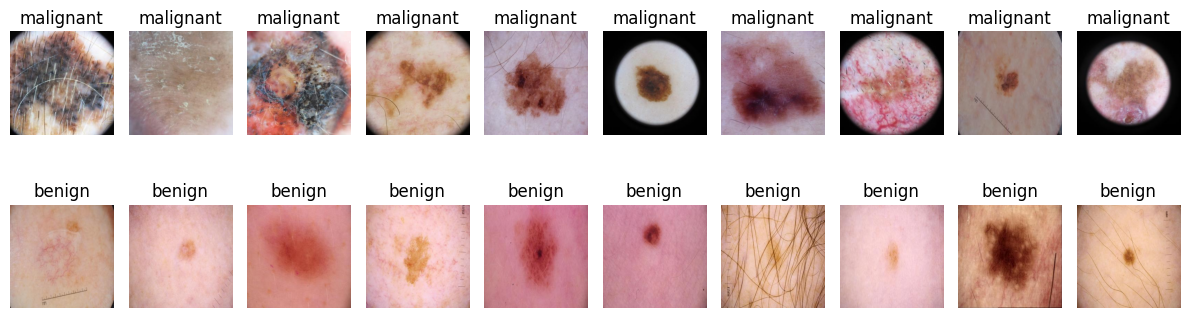

In [ ]:
num_images_to_show = 10
num_rows = len(list_)
num_cols = num_images_to_show
data_path = data_path

plot_image(num_images_to_show, num_rows, num_cols, data_path)

In [ ]:
NAME2NUMBER = {}
for index, label in enumerate(list_):
  NAME2NUMBER[label] = index

def get_path(path):
  paths = []
  for name in list_:
    l = glob.glob(f"{path}{name}/*.jpg")
    for i in l:
      paths.append({"name": name,
                    "path": i,
                    "label": NAME2NUMBER[name]})
  return paths

In [ ]:
data_paths = get_path(data_path)

In [ ]:
class DataSet(torch.utils.data.Dataset):

  def __init__(self, features, new_size = (224,224)):
    super(DataSet, self).__init__()
    self.features = features
    self.resize_transform = torchvision.transforms.Resize(new_size)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    paths = self.features[idx]["path"]
    image = torchvision.io.read_image(paths) / 255.0
    image = self.resize_transform(image)
    label = torch.tensor(self.features[idx]["label"])
    return {"image": image,
            "label": label}

Data = DataSet(data_paths)

In [ ]:
next(iter(Data))["image"].shape

torch.Size([3, 224, 224])

In [ ]:
class DataModule(L.LightningDataModule):
  def __init__(self, batch_size, num_workers, data_path):
    super(DataModule, self).__init__()
    self.data_path = data_path
    self.batch_size = batch_size
    self.num_workers = num_workers

  def setup(self, stage=None):
    data_paths = get_path(self.data_path)
    train_paths, val_paths = train_test_split(data_paths, test_size=0.2, random_state=0)
    train_paths, test_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

    self.train_dataset = DataSet(train_paths)
    self.val_dataset = DataSet(val_paths)
    self.test_dataset = DataSet(test_paths)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)

data_module = DataModule(32, 1, data_path)
data_module.setup()
test_loader = data_module.test_dataloader()
next(iter(test_loader))

{'image': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
           [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0

## Training Phase

Các mô hình được xây dựng trên framework Pytorch Lightning, khởi tạo mô hình được cài sẵn từ thư viện torchvision và sử dụng các độ đo như loss, accuracy, precision, recal, f1 để đánh giá mô hình. Ngoài phần xây dựng các tham số cho mô hình (ở phần init) thì các phương thức còn lại đều giống nhau nên ở đây chúng tôi sẽ trình bày về các phương thức giống nhau trong các mô hình, còn điểm khác biệt ở mỗi mô hình sẽ được trình bày trước cell code của mô hình đó.

Phương thức forward(): phương thức này thực hiện quá trình chuyển tiếp của mô hình. Đưa đầu vào 'x' vào mô hình tạo ra một biểu diễn sau cùng, sau đó flatten các biểu diễn để đưa là phần classifier.

Các phương thức train_step, validation_step, test_step là các phương thức thực hiện quá trình lan truyền thuận trong các giai đoạn huấn luyện, đánh giá và kiểm tra. Trong mỗi phương thức, tính toán loss dựa trên đầu ra dự đoán và nhãn thực tế, sau đó log các độ đo loss, accuracy, f1 score, recall, precision.

Phương thức predict_step được sử dụng để dự đoán dữ liệu trên một batch mới. Nó tính xác suất đầu ra sử dụng hàm softmax và sau đó chọn lớp có xác suất cao nhất làm dự đoán.

Phương thức configure_optimizers: định nghĩa tối ưu hoá sử dụng Adam optimizer với learning rate được cài đặt trước đó.




### alexnet

Khởi tạo mô hình với kiến trúc AlexNet. Đóng băng các tham số của mô hình bằng cách cài đặt requires_grad = False để không huấn luyện lại chúng. Sau đó, xác định số lượng đặc trưng đầu ra cuối cùng của mô hình AlexNet và khởi tạo mô hình tuyến tính mới là phần classifier (self.classifier = nn.Sequential(...)). Trong đó, sử dụng các lớp tuyến tính đi kèm với hàm kích hoạt ReLU và Dropout với p = 0.5 để tránh overfitting. Lưu lại giá trị learning rate và khởi tạo giá trị loss bằng hàm CrossEntropyLoss() cùng các độ đo (accuracy, precision, recal, f1) để đánh giá mô hình.



In [ ]:
class alexnet(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2, dropout: float = 0.5):
    super(alexnet, self).__init__()
    backbone = torchvision.models.alexnet(pretrained=True)

    for param in backbone.parameters():
      param.requires_grad = False

    layers = list(backbone.children())[:-1]

    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Sequential(
                                  nn.Dropout(p=dropout),
                                  nn.Linear(256 * 6 * 6, 4096),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(4096, 4096),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(4096, num_target_classes),
                              )
    self.is_train = is_train
    self.learning_rate = learning_rate

    self.loss = torch.nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.classification.BinaryAccuracy()
    self.f1 = torchmetrics.classification.BinaryF1Score()
    self.recall = torchmetrics.classification.BinaryRecall()
    self.precision = torchmetrics.classification.BinaryPrecision()

  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    acc = self.accuracy(predictions, y)
    self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    val_loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    val_acc = self.accuracy(predictions, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    test_loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    test_acc = self.accuracy(predictions, y)
    test_f1 = self.f1(predictions, y)
    test_recall = self.recall(predictions, y)
    test_precision = self.precision(predictions, y)

    self.log_dict({"test_loss": test_loss,
                      "test_acc": test_acc,
                      "test_f1": test_f1,
                      "test_recall": test_recall,
                      "test_precision": test_precision},
                      prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, _ = batch["image"], batch['label']
    probabilities = self(x).softmax(dim=1)
    y_pred = torch.argmax(probabilities, dim=1)
    return y_pred

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = alexnet()
data_module = DataModule(512, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 2.5 M 
1 | classifier        | Sequential       | 54.5 M
2 | loss              | CrossEntropyLoss | 0     
3 | accuracy          | BinaryAccuracy   | 0     
4 | f1                | BinaryF1Score    | 0     
5 | recall            | BinaryRecall     | 0     
6 | precision         | BinaryPrecision  | 0     
-------------------------------------------------------
54.5 M    Trainable params
2.5 M     Non-trainable params
57.0 M    Total params
228.048   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 2.5 M 
1 | classifier  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 14: 'val_acc' reached 0.80339 (best 0.80339), saving model to '/content/checkpoint/epoch=0-step=14-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 14: 'val_acc' reached 0.80339 (best 0.80339), saving model to '/content/checkpoint/epoch=0-step=14-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 28: 'val_acc' reached 0.87082 (best 0.87082), saving model to '/content/checkpoint/epoch=1-step=28.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 28: 'val_acc' reached 0.87082 (best 0.87082), saving model to '/content/checkpoint/epoch=1-step=28.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 42: 'val_acc' reached 0.89250 (best 0.89250), saving model to '/content/checkpoint/epoch=2-step=42.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 42: 'val_acc' reached 0.89250 (best 0.89250), saving model to '/content/checkpoint/epoch=2-step=42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 56: 'val_acc' reached 0.89769 (best 0.89769), saving model to '/content/checkpoint/epoch=3-step=56.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 56: 'val_acc' reached 0.89769 (best 0.89769), saving model to '/content/checkpoint/epoch=3-step=56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 70: 'val_acc' reached 0.90853 (best 0.90853), saving model to '/content/checkpoint/epoch=4-step=70.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 70: 'val_acc' reached 0.90853 (best 0.90853), saving model to '/content/checkpoint/epoch=4-step=70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 84: 'val_acc' reached 0.90948 (best 0.90948), saving model to '/content/checkpoint/epoch=5-step=84.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 84: 'val_acc' reached 0.90948 (best 0.90948), saving model to '/content/checkpoint/epoch=5-step=84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 98: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/epoch=6-step=98.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 98: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/epoch=6-step=98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 112: 'val_acc' reached 0.91749 (best 0.91749), saving model to '/content/checkpoint/epoch=7-step=112.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 112: 'val_acc' reached 0.91749 (best 0.91749), saving model to '/content/checkpoint/epoch=7-step=112.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 126: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 126: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 140: 'val_acc' reached 0.91891 (best 0.91891), saving model to '/content/checkpoint/epoch=9-step=140.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 140: 'val_acc' reached 0.91891 (best 0.91891), saving model to '/content/checkpoint/epoch=9-step=140.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 154: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 154: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 168: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 168: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 182: 'val_acc' reached 0.92362 (best 0.92362), saving model to '/content/checkpoint/epoch=12-step=182.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 182: 'val_acc' reached 0.92362 (best 0.92362), saving model to '/content/checkpoint/epoch=12-step=182.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 196: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 196: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 210: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 210: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 224: 'val_acc' reached 0.93069 (best 0.93069), saving model to '/content/checkpoint/epoch=15-step=224.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 224: 'val_acc' reached 0.93069 (best 0.93069), saving model to '/content/checkpoint/epoch=15-step=224.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 238: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 238: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 252: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 252: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 266: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 266: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 280: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 280: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 294: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 294: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.931644082069397     │
│          test_f1          │    0.9321092963218689     │
│         test_loss         │    0.22181512415409088    │
│      test_precision       │    0.9184646606445312     │
│        test_recall        │    0.9463866949081421     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22181512415409088,
  'test_acc': 0.931644082069397,
  'test_f1': 0.9321092963218689,
  'test_recall': 0.9463866949081421,
  'test_precision': 0.9184646606445312}]

### vgg19_bn
Khởi tạo mô hình với kiến trúc vgg19_bn. Đóng băng các tham số của mô hình bằng cách cài đặt requires_grad = False để không huấn luyện lại chúng. Xác định số lượng đặc trưng đầu ra của lớp cuối cùng trong mô hình VGG19 dựa trên giả định rằng kích thước của feature map cuối cùng là 7x7 và có 512 kênh. Sau đó, khởi tạo mô hình tuyến tính mới là phần classifier với với số lượng đầu ra là num_target_classes..

In [ ]:
class vgg19_bn(L.LightningModule):
    def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
      super(vgg19_bn, self).__init__()

      backbone = torchvision.models.vgg19_bn(pretrained=True)
      for param in backbone.parameters():
                param.requires_grad = False

      #num_filters = backbone.classifier[-1].out_features
      num_filters = 512 * 7 * 7  # Assuming 7x7 is the size of the last feature map

      layers = list(backbone.children())[:-1]

      self.feature_extractor = torch.nn.Sequential(*layers)
      self.classifier = nn.Linear(num_filters, num_target_classes)
      self.is_train = is_train
      self.learning_rate = learning_rate

      self.loss = torch.nn.CrossEntropyLoss()
      self.accuracy = torchmetrics.classification.BinaryAccuracy()
      self.f1 = torchmetrics.classification.BinaryF1Score()
      self.recall = torchmetrics.classification.BinaryRecall()
      self.precision = torchmetrics.classification.BinaryPrecision()


    def forward(self, x):
      x = self.feature_extractor(x)
      x = x.view(x.size(0), -1)  # Flatten the tensor for the linear layer

      # Always apply the linear layer during forward pass
      x = self.classifier(x)

      return x

    def training_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      acc = self.accuracy(predictions, y)
      self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
      return loss

    def validation_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      val_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      val_acc = self.accuracy(predictions, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      test_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      test_acc = self.accuracy(predictions, y)
      test_f1 = self.f1(predictions, y)
      test_recall = self.recall(predictions, y)
      test_precision = self.precision(predictions, y)

      self.log_dict({"test_loss": test_loss,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "test_recall": test_recall,
                        "test_precision": test_precision},
                        prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx):
      x, _ = batch["image"], batch['label']
      probabilities = self(x).softmax(dim=1)
      y_pred = torch.argmax(probabilities, dim=1)
      return y_pred

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = vgg19_bn()
data_module = DataModule(512, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 20.0 M
1 | classifier        | Linear           | 50.2 K
2 | loss              | CrossEntropyLoss | 0     
3 | accuracy          | BinaryAccuracy   | 0     
4 | f1                | BinaryF1Score    | 0     
5 | recall            | BinaryRecall     | 0     
6 | precision         | BinaryPrecision  | 0     
-------------------------------------------------------
50.2 K    Trainable params
20.0 M    Non-trainable params
20.1 M    Total params
80.342    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 20.0 M
1 | classifier  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 14: 'val_acc' reached 0.80622 (best 0.80622), saving model to '/content/checkpoint/epoch=0-step=14.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 14: 'val_acc' reached 0.80622 (best 0.80622), saving model to '/content/checkpoint/epoch=0-step=14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 28: 'val_acc' reached 0.85761 (best 0.85761), saving model to '/content/checkpoint/epoch=1-step=28.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 28: 'val_acc' reached 0.85761 (best 0.85761), saving model to '/content/checkpoint/epoch=1-step=28.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 42: 'val_acc' reached 0.89250 (best 0.89250), saving model to '/content/checkpoint/epoch=2-step=42.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 42: 'val_acc' reached 0.89250 (best 0.89250), saving model to '/content/checkpoint/epoch=2-step=42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 56: 'val_acc' reached 0.90806 (best 0.90806), saving model to '/content/checkpoint/epoch=3-step=56.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 56: 'val_acc' reached 0.90806 (best 0.90806), saving model to '/content/checkpoint/epoch=3-step=56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 70: 'val_acc' reached 0.91466 (best 0.91466), saving model to '/content/checkpoint/epoch=4-step=70.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 70: 'val_acc' reached 0.91466 (best 0.91466), saving model to '/content/checkpoint/epoch=4-step=70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 84: 'val_acc' reached 0.91561 (best 0.91561), saving model to '/content/checkpoint/epoch=5-step=84.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 84: 'val_acc' reached 0.91561 (best 0.91561), saving model to '/content/checkpoint/epoch=5-step=84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 98: 'val_acc' reached 0.91843 (best 0.91843), saving model to '/content/checkpoint/epoch=6-step=98.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 98: 'val_acc' reached 0.91843 (best 0.91843), saving model to '/content/checkpoint/epoch=6-step=98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 112: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 112: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 126: 'val_acc' reached 0.92079 (best 0.92079), saving model to '/content/checkpoint/epoch=8-step=126.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 126: 'val_acc' reached 0.92079 (best 0.92079), saving model to '/content/checkpoint/epoch=8-step=126.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 140: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 140: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 154: 'val_acc' reached 0.92598 (best 0.92598), saving model to '/content/checkpoint/epoch=10-step=154.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 154: 'val_acc' reached 0.92598 (best 0.92598), saving model to '/content/checkpoint/epoch=10-step=154.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 168: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 168: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 182: 'val_acc' reached 0.92692 (best 0.92692), saving model to '/content/checkpoint/epoch=12-step=182.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 182: 'val_acc' reached 0.92692 (best 0.92692), saving model to '/content/checkpoint/epoch=12-step=182.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 196: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 196: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 210: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 210: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 224: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 224: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 238: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 238: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 252: 'val_acc' reached 0.92975 (best 0.92975), saving model to '/content/checkpoint/epoch=17-step=252.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 252: 'val_acc' reached 0.92975 (best 0.92975), saving model to '/content/checkpoint/epoch=17-step=252.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 266: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 266: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 280: 'val_acc' reached 0.93022 (best 0.93022), saving model to '/content/checkpoint/epoch=19-step=280.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 280: 'val_acc' reached 0.93022 (best 0.93022), saving model to '/content/checkpoint/epoch=19-step=280.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 294: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 294: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 308: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 308: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 322: 'val_acc' reached 0.93305 (best 0.93305), saving model to '/content/checkpoint/epoch=22-step=322.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 322: 'val_acc' reached 0.93305 (best 0.93305), saving model to '/content/checkpoint/epoch=22-step=322.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 336: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 336: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 24, global step 350: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 350: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 25, global step 364: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 364: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 378: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 378: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 27, global step 392: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 392: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9275191426277161     │
│          test_f1          │    0.9279593825340271     │
│         test_loss         │    0.19177645444869995    │
│      test_precision       │    0.9166999459266663     │
│        test_recall        │    0.9400001168251038     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19177645444869995,
  'test_acc': 0.9275191426277161,
  'test_f1': 0.9279593825340271,
  'test_recall': 0.9400001168251038,
  'test_precision': 0.9166999459266663}]

### resnext101_64x4d
Xây dựng model resnet101 tương tự các model trên. ResNet-101 64 4d là một kiến trúc mạng nơ-ron tích chập (CNN). Đây là một biến thể của kiến trúc ResNet sử dụng phép tích chập 4D thay cho phép tích chập 2D được sử dụng trong ResNet gốc. Điều này cho phép ResNet-101 64x4d học được các đặc trưng phức tạp hơn từ hình ảnh đầu vào. Kiến trúc ResNet-101 64x4d bao gồm 101 tầng, được chia thành 34 khối residual.


In [ ]:
class resnext101_64x4d(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
    super(resnext101_64x4d, self).__init__()
    backbone = torchvision.models.resnext101_64x4d(weights="DEFAULT")

    for param in backbone.parameters():
      param.requires_grad = False

    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]

    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Linear(num_filters, num_target_classes)
    self.is_train = is_train
    self.learning_rate = learning_rate
    self.loss = torch.nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.classification.BinaryAccuracy()
    self.f1 = torchmetrics.classification.BinaryF1Score()
    self.recall = torchmetrics.classification.BinaryRecall()
    self.precision = torchmetrics.classification.BinaryPrecision()

  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    acc = self.accuracy(predictions, y)
    self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    val_loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    val_acc = self.accuracy(predictions, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    test_loss = self.loss(y_pred, y)

    predictions = torch.argmax(y_pred, dim=1)
    test_acc = self.accuracy(predictions, y)
    test_f1 = self.f1(predictions, y)
    test_recall = self.recall(predictions, y)
    test_precision = self.precision(predictions, y)

    self.log_dict({"test_loss": test_loss,
                      "test_acc": test_acc,
                      "test_f1": test_f1,
                      "test_recall": test_recall,
                      "test_precision": test_precision},
                      prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, _ = batch["image"], batch['label']
    probabilities = self(x).softmax(dim=1)
    y_pred = torch.argmax(probabilities, dim=1)
    return y_pred

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = resnext101_64x4d()
data_module = DataModule(256, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)

Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:02<00:00, 150MB/s]
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:

In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 81.4 M
1 | classifier        | Linear           | 4.1 K 
2 | loss              | CrossEntropyLoss | 0     
3 | accuracy          | BinaryAccuracy   | 0     
4 | f1                | BinaryF1Score    | 0     
5 | recall            | BinaryRecall     | 0     
6 | precision         | BinaryPrecision  | 0     
-------------------------------------------------------
4.1 K     Trainable params
81.4 M    Non-trainable params
81.4 M    Total params
325.641   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 81.4 M
1 | classifier  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 27: 'val_acc' reached 0.87459 (best 0.87459), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 27: 'val_acc' reached 0.87459 (best 0.87459), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 54: 'val_acc' reached 0.88732 (best 0.88732), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 54: 'val_acc' reached 0.88732 (best 0.88732), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 81: 'val_acc' reached 0.89910 (best 0.89910), saving model to '/content/checkpoint/epoch=2-step=81.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 81: 'val_acc' reached 0.89910 (best 0.89910), saving model to '/content/checkpoint/epoch=2-step=81.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 108: 'val_acc' reached 0.90335 (best 0.90335), saving model to '/content/checkpoint/epoch=3-step=108.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 108: 'val_acc' reached 0.90335 (best 0.90335), saving model to '/content/checkpoint/epoch=3-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 135: 'val_acc' reached 0.90665 (best 0.90665), saving model to '/content/checkpoint/epoch=4-step=135.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 135: 'val_acc' reached 0.90665 (best 0.90665), saving model to '/content/checkpoint/epoch=4-step=135.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 162: 'val_acc' reached 0.90995 (best 0.90995), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 162: 'val_acc' reached 0.90995 (best 0.90995), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 189: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 189: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 216: 'val_acc' reached 0.91325 (best 0.91325), saving model to '/content/checkpoint/epoch=7-step=216.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 216: 'val_acc' reached 0.91325 (best 0.91325), saving model to '/content/checkpoint/epoch=7-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 243: 'val_acc' reached 0.91702 (best 0.91702), saving model to '/content/checkpoint/epoch=8-step=243.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 243: 'val_acc' reached 0.91702 (best 0.91702), saving model to '/content/checkpoint/epoch=8-step=243.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 270: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 270: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 297: 'val_acc' reached 0.91891 (best 0.91891), saving model to '/content/checkpoint/epoch=10-step=297.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 297: 'val_acc' reached 0.91891 (best 0.91891), saving model to '/content/checkpoint/epoch=10-step=297.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 324: 'val_acc' reached 0.91938 (best 0.91938), saving model to '/content/checkpoint/epoch=11-step=324.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 324: 'val_acc' reached 0.91938 (best 0.91938), saving model to '/content/checkpoint/epoch=11-step=324.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 351: 'val_acc' reached 0.91985 (best 0.91985), saving model to '/content/checkpoint/epoch=12-step=351.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 351: 'val_acc' reached 0.91985 (best 0.91985), saving model to '/content/checkpoint/epoch=12-step=351.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 378: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 378: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 405: 'val_acc' reached 0.92174 (best 0.92174), saving model to '/content/checkpoint/epoch=14-step=405.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 405: 'val_acc' reached 0.92174 (best 0.92174), saving model to '/content/checkpoint/epoch=14-step=405.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 432: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 432: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 459: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/epoch=16-step=459.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 459: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/epoch=16-step=459.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 486: 'val_acc' reached 0.92456 (best 0.92456), saving model to '/content/checkpoint/epoch=17-step=486.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 486: 'val_acc' reached 0.92456 (best 0.92456), saving model to '/content/checkpoint/epoch=17-step=486.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 513: 'val_acc' reached 0.92786 (best 0.92786), saving model to '/content/checkpoint/epoch=18-step=513.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 513: 'val_acc' reached 0.92786 (best 0.92786), saving model to '/content/checkpoint/epoch=18-step=513.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 540: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 540: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 567: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 567: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 594: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 594: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 621: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 621: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 648: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 648: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9292869567871094     │
│          test_f1          │    0.9301661252975464     │
│         test_loss         │    0.19531665742397308    │
│      test_precision       │    0.9213492274284363     │
│        test_recall        │    0.9396917223930359     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19531665742397308,
  'test_acc': 0.9292869567871094,
  'test_f1': 0.9301661252975464,
  'test_recall': 0.9396917223930359,
  'test_precision': 0.9213492274284363}]

### densenet121

Khởi tạo mô hình với kiến trúc densenet121. Tương tự các mô hình trước, đóng băng các tham số của mô hình bằng cách cài đặt requires_grad = False. Sau đó, xác định số lượng đặc trưng đầu ra cuối cùng của mô hình densenet121 và khởi tạo mô hình tuyến tính mới là phần classifier (self.classifier = nn.Sequential(...)). Trong đó, sử dụng 2 lớp tuyến tính, lớp thứ nhất đi kèm với hàm kích hoạt ReLU và Dropout với p = 0.5 để tránh overfitting, lớp thứ hai với đầu ra là num_target_classes = 2 kết hợp với hàm kích hoạt sigmoid cho bài toán phân lớp nhị phân.


In [ ]:
class densenet(L.LightningModule):
    def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
      super(densenet, self).__init__()

      self.backbone = torchvision.models.densenet121(pretrained=True)
      for param in self.backbone.parameters():
                param.requires_grad = False

      num_ftrs = self.backbone.classifier.out_features

      self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_target_classes),
            nn.Sigmoid()
        )

      self.is_train = is_train
      self.learning_rate = learning_rate

      self.loss = torch.nn.CrossEntropyLoss()
      self.accuracy = torchmetrics.classification.BinaryAccuracy()
      self.f1 = torchmetrics.classification.BinaryF1Score()
      self.recall = torchmetrics.classification.BinaryRecall()
      self.precision = torchmetrics.classification.BinaryPrecision()

    def forward(self, x):
      x = self.backbone(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x

    def training_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      acc = self.accuracy(predictions, y)
      self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
      return loss

    def validation_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      val_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      val_acc = self.accuracy(predictions, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      test_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      test_acc = self.accuracy(predictions, y)
      test_f1 = self.f1(predictions, y)
      test_recall = self.recall(predictions, y)
      test_precision = self.precision(predictions, y)

      self.log_dict({"test_loss": test_loss,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "test_recall": test_recall,
                        "test_precision": test_precision},
                        prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx):
      x, _ = batch["image"], batch['label']
      probabilities = self(x).softmax(dim=1)
      y_pred = torch.argmax(probabilities, dim=1)
      return y_pred

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = densenet()
data_module = DataModule(128, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = densenet()
data_module = DataModule(256, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 27: 'val_acc' reached 0.89298 (best 0.89298), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 27: 'val_acc' reached 0.89298 (best 0.89298), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 54: 'val_acc' reached 0.91089 (best 0.91089), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 54: 'val_acc' reached 0.91089 (best 0.91089), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 81: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 81: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias p

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 108: 'val_acc' reached 0.91419 (best 0.91419), saving model to '/content/checkpoint/epoch=3-step=108.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 108: 'val_acc' reached 0.91419 (best 0.91419), saving model to '/content/checkpoint/epoch=3-step=108.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 135: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 135: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 162: 'val_acc' reached 0.92126 (best 0.92126), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 162: 'val_acc' reached 0.92126 (best 0.92126), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 189: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 189: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 216: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 216: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 243: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 243: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 270: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 270: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 297: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 297: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9263405799865723     │
│          test_f1          │    0.9263384342193604     │
│         test_loss         │    0.3836638331413269     │
│      test_precision       │    0.9264854192733765     │
│        test_recall        │    0.9271486401557922     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3836638331413269,
  'test_acc': 0.9263405799865723,
  'test_f1': 0.9263384342193604,
  'test_recall': 0.9271486401557922,
  'test_precision': 0.9264854192733765}]

### mobilenet_v2

Khởi tạo mô hình với kiến trúc mobilenet_v2. Tương tự các mô hình trước, đóng băng các tham số của mô hình bằng cách cài đặt requires_grad = False. Sau đó, xác định số lượng đặc trưng đầu ra cuối cùng của mô hình mobilenet_v2 và khởi tạo mô hình tuyến tính mới là phần classifier (self.classifier = nn.Sequential(...)). Trong đó, sử dụng 2 lớp tuyến tính, lớp thứ nhất đi kèm với hàm kích hoạt ReLU và Dropout với p = 0.3 để tránh overfitting, lớp thứ hai với đầu ra là num_target_classes = 2 kết hợp với hàm kích hoạt sigmoid cho bài toán phân lớp nhị phân.


In [ ]:
class mobilenetv2(L.LightningModule):
    def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
      super(mobilenetv2, self).__init__()

      self.backbone = torchvision.models.mobilenet_v2(pretrained=True)
      for param in self.backbone.parameters():
                param.requires_grad = False

      num_ftrs = self.backbone.classifier[-1].out_features

      self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_target_classes),
            nn.Sigmoid()
        )

      self.is_train = is_train
      self.learning_rate = learning_rate

      self.loss = torch.nn.CrossEntropyLoss()
      self.accuracy = torchmetrics.classification.BinaryAccuracy()
      self.f1 = torchmetrics.classification.BinaryF1Score()
      self.recall = torchmetrics.classification.BinaryRecall()
      self.precision = torchmetrics.classification.BinaryPrecision()

    def forward(self, x):
      x = self.backbone(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x

    def training_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      acc = self.accuracy(predictions, y)
      self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
      return loss

    def validation_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      val_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      val_acc = self.accuracy(predictions, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      test_loss = self.loss(y_pred, y)

      predictions = torch.argmax(y_pred, dim=1)
      test_acc = self.accuracy(predictions, y)
      test_f1 = self.f1(predictions, y)
      test_recall = self.recall(predictions, y)
      test_precision = self.precision(predictions, y)

      self.log_dict({"test_loss": test_loss,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "test_recall": test_recall,
                        "test_precision": test_precision},
                        prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx):
      x, _ = batch["image"], batch['label']
      probabilities = self(x).softmax(dim=1)
      y_pred = torch.argmax(probabilities, dim=1)
      return y_pred

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = mobilenetv2()
data_module = DataModule(256, 1, data_path)
trainer = L.Trainer(max_epochs= 100, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  w

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 27: 'val_acc' reached 0.87977 (best 0.87977), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 27: 'val_acc' reached 0.87977 (best 0.87977), saving model to '/content/checkpoint/epoch=0-step=27.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 54: 'val_acc' reached 0.90995 (best 0.90995), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 54: 'val_acc' reached 0.90995 (best 0.90995), saving model to '/content/checkpoint/epoch=1-step=54.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 81: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 81: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias p

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 108: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 108: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 135: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 135: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 162: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 162: 'val_acc' reached 0.91136 (best 0.91136), saving model to '/content/checkpoint/epoch=5-step=162.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 189: 'val_acc' reached 0.91183 (best 0.91183), saving model to '/content/checkpoint/epoch=6-step=189.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 189: 'val_acc' reached 0.91183 (best 0.91183), saving model to '/content/checkpoint/epoch=6-step=189.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 216: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 216: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 243: 'val_acc' reached 0.91608 (best 0.91608), saving model to '/content/checkpoint/epoch=8-step=243.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 243: 'val_acc' reached 0.91608 (best 0.91608), saving model to '/content/checkpoint/epoch=8-step=243.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 270: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 270: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 297: 'val_acc' reached 0.91702 (best 0.91702), saving model to '/content/checkpoint/epoch=10-step=297.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 297: 'val_acc' reached 0.91702 (best 0.91702), saving model to '/content/checkpoint/epoch=10-step=297.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 324: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 324: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 351: 'val_acc' reached 0.91749 (best 0.91749), saving model to '/content/checkpoint/epoch=12-step=351.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 351: 'val_acc' reached 0.91749 (best 0.91749), saving model to '/content/checkpoint/epoch=12-step=351.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 378: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 378: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 405: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/epoch=14-step=405.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 405: 'val_acc' reached 0.92221 (best 0.92221), saving model to '/content/checkpoint/epoch=14-step=405.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 432: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 432: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 459: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 459: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 486: 'val_acc' reached 0.92315 (best 0.92315), saving model to '/content/checkpoint/epoch=17-step=486.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 486: 'val_acc' reached 0.92315 (best 0.92315), saving model to '/content/checkpoint/epoch=17-step=486.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 513: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 513: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 540: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 540: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 567: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 567: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 594: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 594: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antiali

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 621: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 621: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also a

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9233942031860352     │
│          test_f1          │    0.9236893057823181     │
│         test_loss         │    0.38610756397247314    │
│      test_precision       │    0.9208922386169434     │
│        test_recall        │    0.9271844029426575     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.38610756397247314,
  'test_acc': 0.9233942031860352,
  'test_f1': 0.9236893057823181,
  'test_recall': 0.9271844029426575,
  'test_precision': 0.9208922386169434}]

### Kết luận

Những model đã học được dùng để giải quyết bài toán phân biệt được khối u ác tính với một ảnh đầu vào:  

- **$ALEXNET$**  

Info|Params|
-|:-:|
feature_extractor|2.5 M |
classifier|54.5 M|

- **$VGG19(BN)$**  

Info|Params|
-|:-:|
feature_extractor|20.0 M |
classifier|50.2 K|


- **$RESNET101(64x4D)$**  


Info|Params|
-|:-:|
feature_extractor|81.4 M |
classifier|4.1 K|




- **$DENSENET121$**

Info|Params|
-|:-:|
backbone r|8.0 M |
classifier|256 K |

- **$MOBILENET(V2)$**

Info|Params|
-|:-:|
backbone |3.5 M|
classifier|513 K|


Như vậy, ta có bảng kết luận $accuracy$ ,$f1score$ ,$precision$ ,$recall$ như sau:

Model|ACC|F1_score|Precision|Recall|
-|:-:|:-:|:-:|:-:|
VGG19 (BN)|0.9275|0.9279|0.9166|0.940|
RESNET101(64x4D)|0.9292|0.9301|0.9213|0.9396|
ALEXNET|0.9316|0.932|0.9463|0.918|
DENSENET121|0.9263|0.9263|0.9264|0.9271|
MOBILENET(V2)|0.9233|0.9236|0.9208|0.9271|

Với số lượng data tương đối:   
`len(data_paths) = 10605`  
`len(list(filter(lambda x: x['label'] == 0, data_paths))) = 5105`  
`list(filter(lambda x: x['label'] == 1, data_paths)) = 5500`  

Các mô hình với số lượng `params` khác nhau nhưng kết quả không chênh lệch nhau nhiều, tuy nhiên để tránh overfitting và tối ưu về không gian lẫn thời gian thì `ALEXNET` là lựa chọn tối ưu nhất.